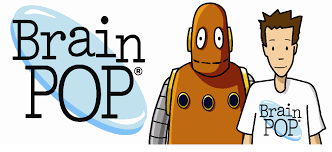

# BrainPOP Practical Skills Assessment

I will be utilizing this Jupyter Notebook to complete the activities outlined in the Skills Assessment. I've created a Google Cloud Database instance to host the data that will be used for the assessment. Supplemental Python and SQL scripts are included in the repository to modularize database operations, fetch external data, and create synthetic student activities.

## Task 1 & 2
### Breakdown of Work
1. DDL Scripts ()
    - Each dataset utilized will have it's own table in the database. DDL Scripts are located in the sql_scripts folder 
    - A table will be created to house Google Trends data for BrainPOP, which will be used as a basis for creating synthetic student interactions. This will account for the duplicated records that are present as a result of the API process.
2. Data Population
    - DML Script included to load initial dataset provided into the Staging table (stg.Student_Activites)
3. Data Cleaning
    - STG Table will be de-duplicated and populated into the main student_activities table
4. Synthetic Data Generation
    - In order to further build on this, I will be creating synthetic 
4. Exploratory Data Analysis
    - Analyze the student_activities table to identify patterns, trends, and anomalies:
    - Distribution of activity types (movies vs. quizzes).
    - Frequency of quizzes occurring after movies.
    - Trends in student performance (e.g., quiz scores).
5. Visualization
    - Create visualizations to showcase key insights, both inline within this notebook and externally using Tableau Public.
    - Focus on trends over time (e.g., month-over-month activity) and segmentation (e.g., by ACCOUNT_ID or STUDENT_ID).


## DDL

I have written a sqlalchemy wrapper class saved as database_operations.py to execute DDL Scripts from the sql_scripts folder

In [1]:
from python_scripts.database_operations import Database
import json

# grab credentials from config.json
with open("config.json", "r") as config_file:
    config = json.load(config_file)

user = config["db_user"]
pw = config["db_pass"]
server = config["db_host"]
port = config["db_port"]
name = config["db_name"]

# connect to the database 
database = Database(db_user = user, db_pass = pw, db_host = server, db_port = port, db_name = name)

# create STG.student_activities and student_activities tables

database.execute_sql_file('/Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DDL/student_activities_ddl.sql')
database.execute_sql_file('/Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DDL/google_trends_ddl.sql')

Executed SQL file: /Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DDL/student_activities_ddl.sql
Executed SQL file: /Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DDL/google_trends_ddl.sql


# Populate Synthetic Data

In order to complete the project, I decided to include synthetic student activities. I will load the last 90 day search history for BrainPOP into the database to use as a proxy for student traffic trends.

## Google Trends Data

This google_trends.py script will grab the last 90 day search history data for the keyword "BrainPOP" using the pytrends library.

In [2]:
from python_scripts.google_trends import fetch_google_trends_90_days
from python_scripts.database_operations import Database

try:
    print("Fetching Google Trends data...")
    trends_df = fetch_google_trends_90_days(keyword="BrainPOP", geo="US")

    if trends_df.empty:
        print("No data fetched from Google Trends.")
    else:
        print(f"Fetched {len(trends_df)} rows of data.")

        try:
            database.load_dataframe(trends_df, table_name="google_trends", if_exists="append")
            print("Google Trends data successfully saved to the database.")
        except Exception as e:
            print(f"Failed to save data to the database: {e}")
finally:
    database.close()


Fetching Google Trends data...


/Users/michaelcurley/.local/share/virtualenvs/BrainPOP-G78lPXsQ/lib/python3.11/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Fetched 93 rows of data.
Google Trends data successfully saved to the database.
Database connection closed.


# DML


I will initially insert the records provided in the sample and use these to test the data cleaning SQL script.

In [3]:
database.execute_sql_file('/Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DML/student_activities_dml.sql')

Executed SQL file: /Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/DML/student_activities_dml.sql


## Data Cleaning

I will be executing the deduplication.sql file to execute the deduplication logic. Duplicates will be maintained in the Staging Table and clean data will be entered into the student_activities table in the BrainPOP schema.

In [4]:
database.execute_sql_file('/Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/Data Cleaning/deduplication.sql')

Executed SQL file: /Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/Data Cleaning/deduplication.sql


## Validation
I've added a simple check to ensure no duplicate entries are entered into the BrainPOP schema.

In [5]:
def check_for_duplicates():
    check_query = 'SELECT * FROM brainpop.student_activities'
    cleaning_check = database.fetch_query(check_query)
    print(f'Size of dataset {cleaning_check.shape}')
    duplicate_ids = cleaning_check[cleaning_check.duplicated(subset=["id"], keep=False)]

    if len(duplicate_ids) > 0:
        print(f"Found {len(duplicate_ids)} duplicate rows in the student_activities table.")
        print(duplicate_ids)
    else:
        print("No duplicate rows found in the student_activities table.")

check_for_duplicates()

Size of dataset (5, 7)
No duplicate rows found in the student_activities table.


## Populate Synthetic Student Records

Now that the data is cleaned and the google trends data is loaded I will use these trends as a proxy for a sample of 100 students login patterns using the following logic:
- For each day in the 90 day sample, I will take the relative frequency out of 100 and randomly choose that number of students as having logged in that day.
- For each student in the random sample on a given day I will generate a random number of interactions from a normal distribuion with a mean of 2 and a standard deviation of 1.5.
- Any quiz scores will be generated using a normal distribution with a mean score of 7 and a standard deviation of 2. Some additional logic will be applied to add for the possibility of very low scores.
- Duplicates that mimic the duplicates created will be synthetically entered to further test the de-dupe logic.

In [6]:
from python_scripts.generate_student_activities import StudentActivityGenerator

generator = StudentActivityGenerator(
        db_user= user,
        db_pass= pw,
        db_host= server,
        db_port= port,
        db_name= name
    )

trends = generator.fetch_google_trends()
sample_students = list(range(1100001, 1100100))  # 100 students
sample_accounts = list(range(8400001, 8400003))  # 3 accounts
generator.generate_student_activities(trends, sample_students, sample_accounts)
generator.save_activities_to_db()
generator.close()



Student activities saved to database.
Database connection closed.


## Data Cleaning

Testing the data cleaning script on this much larger dataset

In [7]:
database.execute_sql_file('/Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/Data Cleaning/deduplication.sql')
# check again for duplicate ids
check_for_duplicates()

Executed SQL file: /Users/michaelcurley/Documents/GitHub/BrainPOP/sql_scripts/Data Cleaning/deduplication.sql
Size of dataset (7869, 7)
No duplicate rows found in the student_activities table.


# Insights
